# Interpolation and extrapolation of calibration data

In [1]:
%matplotlib inline

In [2]:
from meas_data_preprocessing import *
from hydrophone_data_preprocessing import *

In [3]:
from PyDynamic.uncertainty.interpolate import interp1d_unc

## Read measured data and calibration data from file

In [4]:
meas_scenario = 13
infos, measurement_data = read_data(meas_scenario=meas_scenario)
_, hyd_data = read_calib_data(meas_scenario=meas_scenario, do_plot=False)

Checking if file ../datasets/pD7_MH44.DAT is already present or download it from https://raw.githubusercontent.com/Ma-Weber/Tutorial-Deconvolution/master/MeasuredSignals/pD-Mode%207%20MHz/pD7_MH44.DAT otherwise:
Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.
Checking if file ../datasets/pD7_MH44r.DAT is already present or download it from https://raw.githubusercontent.com/Ma-Weber/Tutorial-Deconvolution/master/MeasuredSignals/pD-Mode%207%20MHz/pD7_MH44r.DAT otherwise:
Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.
Checking if file ../datasets/MW_MH44ReIm.csv is already present or download it from https://raw.githubusercontent.com/Ma-Weber/Tutorial-Deconvolution/master/HydrophoneCalibrationData/MW_MH44ReIm.csv otherwise:
Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.
The file ../datasets/pD7_MH44.DAT was read and it contains 2500 data points.
The t

In [5]:
# metadata for chosen measurement scenario
for key in infos.keys():
    print("%20s: %s" % (key, infos[key]))

                   i: 13
       hydrophonname: GAMPT MH44
     measurementtype: Pulse-Doppler-Mode 7 MHz
     measurementfile: ../datasets/pD7_MH44.DAT
           noisefile: ../datasets/pD7_MH44r.DAT
         hydfilename: ../datasets/MW_MH44ReIm.csv


## Perform basic pre-processing

In [6]:
# remove DC component in measured data
measurement_data = remove_DC_component(measurement_data)

In [7]:
# reduce frequency range of calibration data
hyd_data = reduce_freq_range(hyd_data, fmin=1e6, fmax=100e6)

## Align spectral data of calibration and measured data

In [8]:
measurement_data = uncertainty_from_noisefile(
    infos, measurement_data, do_plot=False, verbose=False
)
measurement_data = calculate_spectrum(measurement_data, do_plot=False)
fmeas = measurement_data["frequency"].round()
N = len(fmeas) // 2

### Interpolation of real part

In [9]:
hyd_interp = dict([])
(
    hyd_interp["frequency"],
    hyd_interp["real"],
    hyd_interp["varreal"],
    Creal,
) = interp1d_unc(
    fmeas[:N],
    hyd_data["frequency"],
    hyd_data["real"],
    hyd_data["varreal"],
    bounds_error=False,
    fill_value="extrapolate",
    fill_unc="extrapolate",
    returnC=True,
)

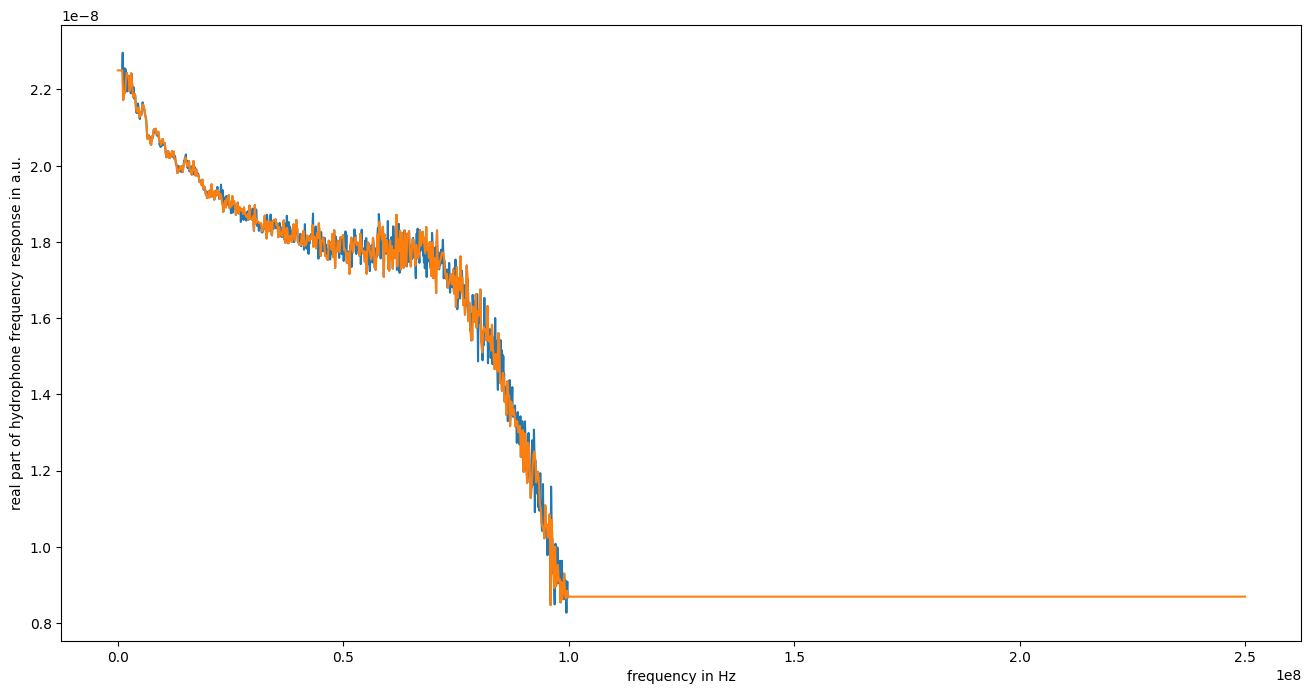

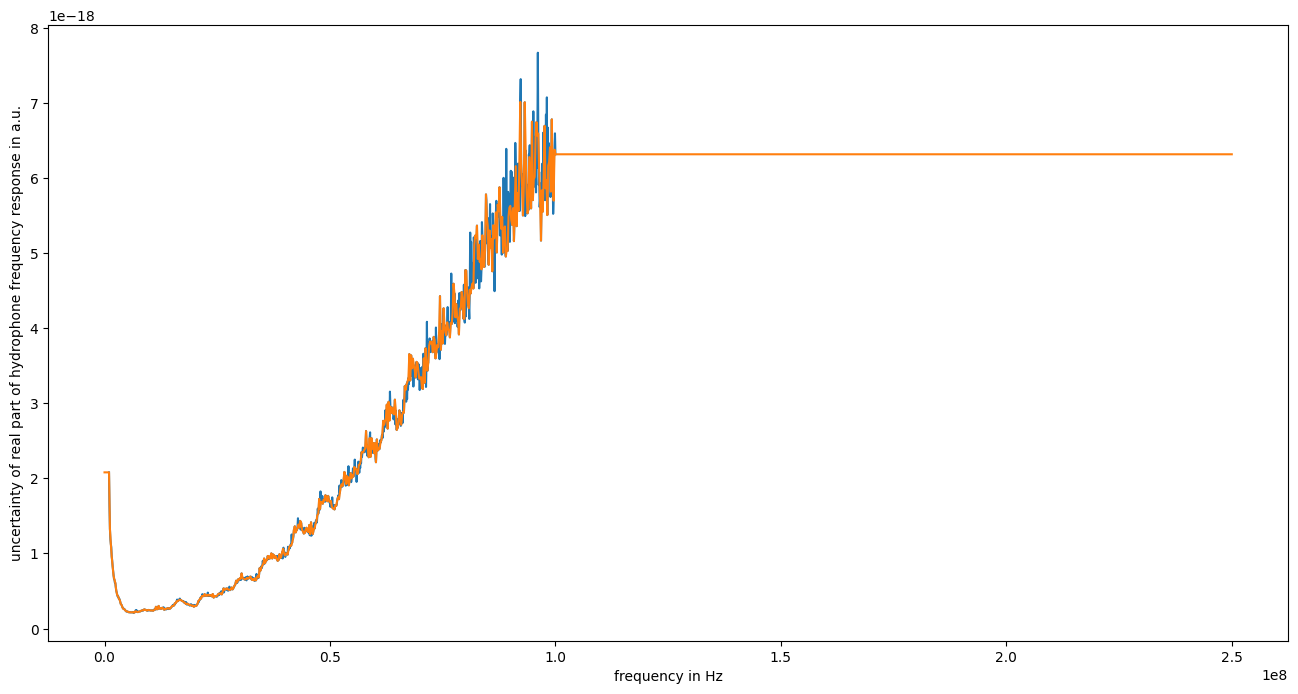

In [10]:
figure(figsize=(16, 8))
plot(hyd_data["frequency"], hyd_data["real"])
plot(hyd_interp["frequency"], hyd_interp["real"])
xlabel("frequency in Hz")
ylabel("real part of hydrophone frequency response in a.u.")

figure(figsize=(16, 8))
plot(hyd_data["frequency"], hyd_data["varreal"])
plot(hyd_interp["frequency"], hyd_interp["varreal"])
xlabel("frequency in Hz")
ylabel("uncertainty of real part of hydrophone frequency response in a.u.")
show()

### Interpolation of imaginary part

In [11]:
(
    hyd_interp["frequency"],
    hyd_interp["imag"],
    hyd_interp["varimag"],
    Cimag,
) = interp1d_unc(
    fmeas[:N],
    hyd_data["frequency"],
    hyd_data["imag"],
    hyd_data["varimag"],
    bounds_error=False,
    fill_value="extrapolate",
    fill_unc="extrapolate",
    returnC=True,
)
# adjustment of end points
hyd_interp["imag"][0] = 0  # Must be 0 by definition
hyd_interp["imag"][-1] = 0
hyd_interp["varimag"][0] = 0  # Must be 0 by definition
hyd_interp["varimag"][-1] = 0

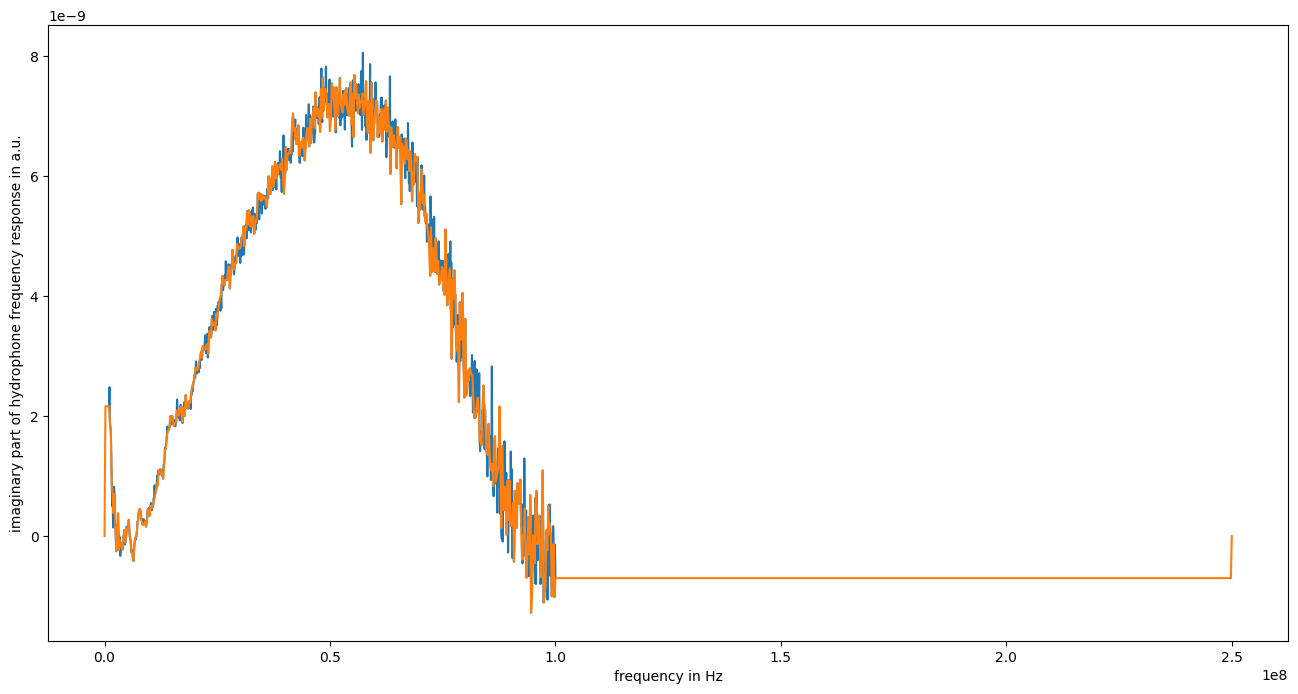

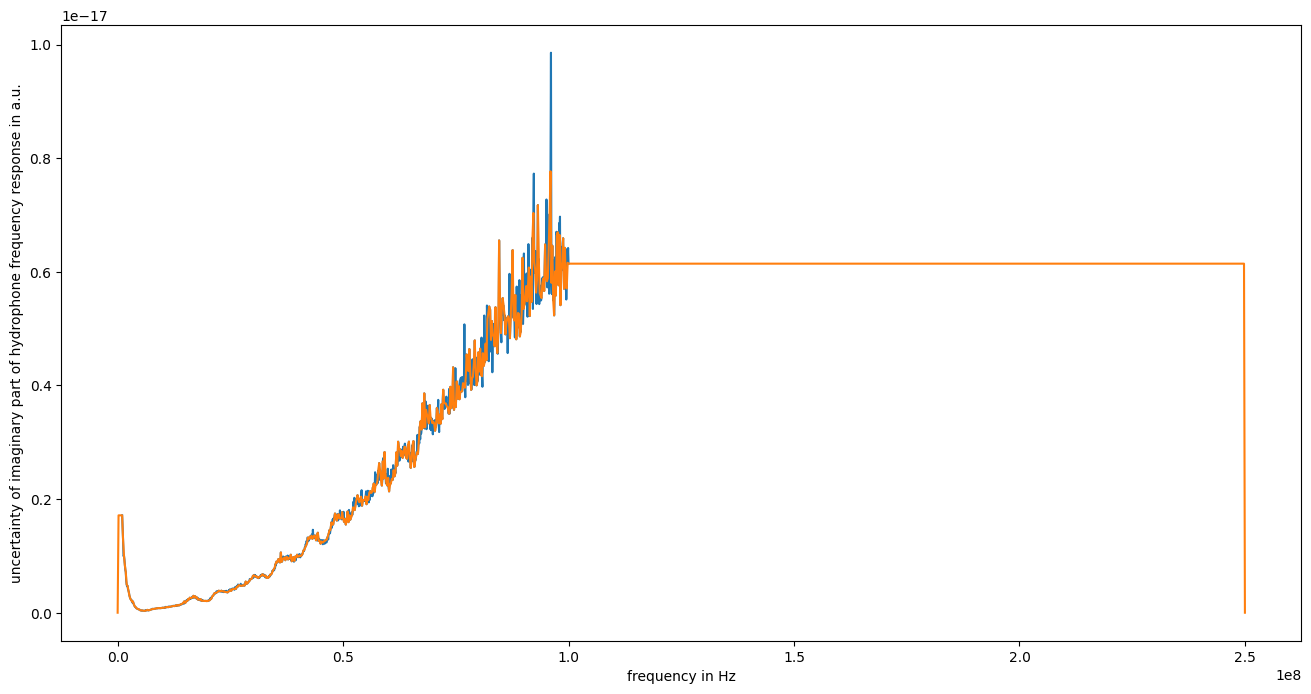

In [12]:
figure(figsize=(16, 8))
plot(hyd_data["frequency"], hyd_data["imag"])
plot(hyd_interp["frequency"], hyd_interp["imag"])
xlabel("frequency in Hz")
ylabel("imaginary part of hydrophone frequency response in a.u.")

figure(figsize=(16, 8))
plot(hyd_data["frequency"], hyd_data["varimag"])
plot(hyd_interp["frequency"], hyd_interp["varimag"])
xlabel("frequency in Hz")
ylabel("uncertainty of imaginary part of hydrophone frequency response in a.u.")
show()

### Calculation of mixed uncertainties at new frequencies

$$ U_{r_{interp},i_{interp}} = C_{r} U_{r,i} C_{i}^T $$

In [13]:
hyd_interp["cov"] = (Creal.dot(np.diag(hyd_data["cov"]))).dot(Cimag.T)

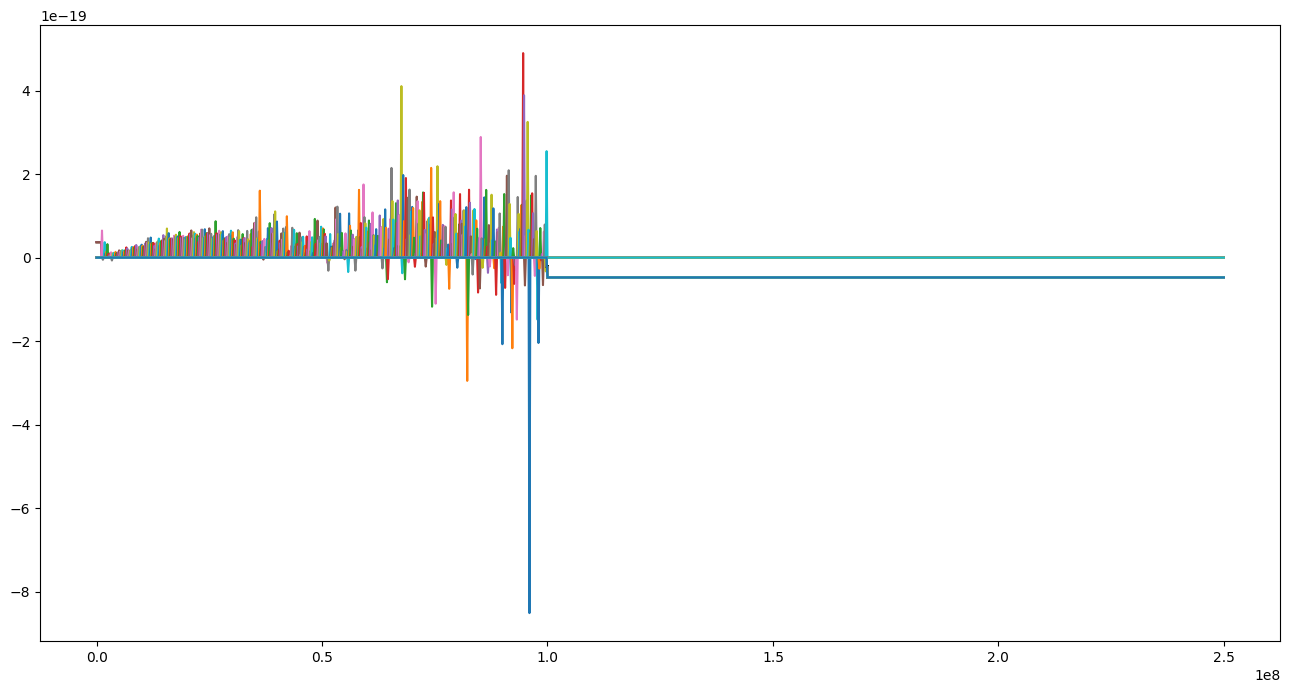

In [14]:
figure(figsize=(16, 8))
plot(hyd_interp["frequency"], hyd_interp["cov"])
show()